# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [28]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [29]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [30]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [31]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_output = DenseLayer(in_features=n_hidden_2, out_features=num_classes)
    # Місце для вашого коду


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    return self.layer_output(x2, activation=1)

In [32]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    prediction = tf.metrics.Accuracy()
    prediction.update_state(y_true, tf.argmax(y_pred, axis=1))
    return prediction.result()

In [33]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    vars = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    grads = g.gradient(loss, vars)
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(grads, vars))

In [34]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Крок: {step} - Функція втрат: {loss:.4f}, Точність: {acc:.3%}")

Крок: 100 - Функція втрат: 816.2113, Точність: 60.938%
Крок: 200 - Функція втрат: 181.5595, Точність: 79.297%
Крок: 300 - Функція втрат: 162.6576, Точність: 79.688%
Крок: 400 - Функція втрат: 188.2163, Точність: 78.516%
Крок: 500 - Функція втрат: 157.5897, Точність: 81.250%
Крок: 600 - Функція втрат: 105.9669, Точність: 87.109%
Крок: 700 - Функція втрат: 155.8775, Точність: 79.688%
Крок: 800 - Функція втрат: 135.6299, Точність: 83.594%
Крок: 900 - Функція втрат: 140.4552, Точність: 85.547%
Крок: 1000 - Функція втрат: 95.3503, Точність: 89.062%
Крок: 1100 - Функція втрат: 116.8522, Точність: 85.938%
Крок: 1200 - Функція втрат: 83.3349, Точність: 91.406%
Крок: 1300 - Функція втрат: 75.3027, Точність: 91.406%
Крок: 1400 - Функція втрат: 71.4160, Точність: 91.016%
Крок: 1500 - Функція втрат: 137.1579, Точність: 84.375%
Крок: 1600 - Функція втрат: 99.7752, Точність: 88.281%
Крок: 1700 - Функція втрат: 47.0186, Точність: 92.969%
Крок: 1800 - Функція втрат: 78.9429, Точність: 90.234%
Крок: 19

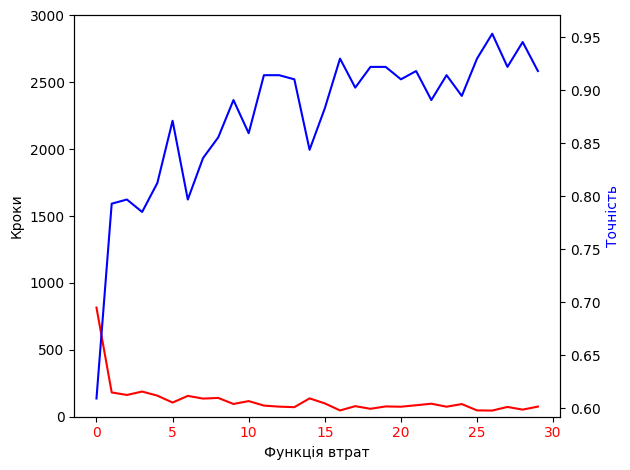

In [35]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись
# Виведіть графік точності
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_ylabel('Кроки')
ax1.set_xlabel('Функція втрат')
ax1.plot(loss_history, color='red')
ax1.set_ylim([0, 3000])
ax1.tick_params(axis='x', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Точність', color='blue')
ax2.plot(accuracy_history, color='blue')
ax2.tick_params(axis='x', labelcolor='blue')

fig.tight_layout()
plt.show()

In [38]:
# Обчисліть точність навченої нейромережі
neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Точність навченої нейромережі: {neural_net_accuracy}")

# Тестування моделі на тестових даних
neural_net_test = accuracy(neural_net(x_test), y_test)
print(f"Точність на тестових даних: {neural_net_test}")

# Матриця помилок
test_pred = neural_net(x_test)
y_pred = np.argmax(test_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
print(f"Матриця помилок: \n{cm}")

Точність навченої нейромережі: 0.9218000173568726
Точність на тестових даних: 0.8996999859809875
Матриця помилок: 
[[ 919    0    3    7    1   26   12    7    4    1]
 [   0 1108    3    2    1    3    3    2   13    0]
 [   9   12  879   35   14    5   15    9   47    7]
 [   1    3   23  888    3   36    1    9   34   12]
 [   2    4    8    4  873    3   16   11    7   54]
 [   6    3    2   40    2  777   15   10   25   12]
 [   9    3    3    2   11   29  889    3    8    1]
 [   0    8   21   11    8    7    0  940    7   26]
 [   4    7   14   23   13   29   11    6  849   18]
 [   2    7    2   13   46   18    1   34   11  875]]


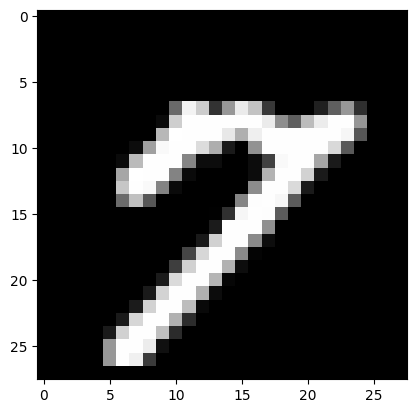

Нейромережа передбачає: 7
Правильна відповідь: 7




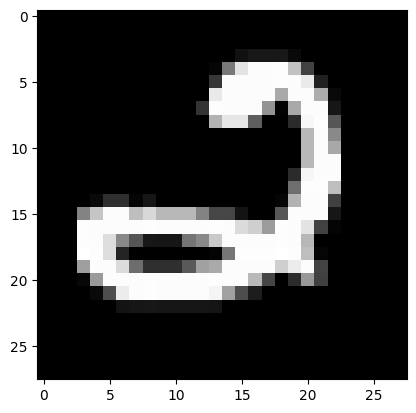

Нейромережа передбачає: 6
Правильна відповідь: 2




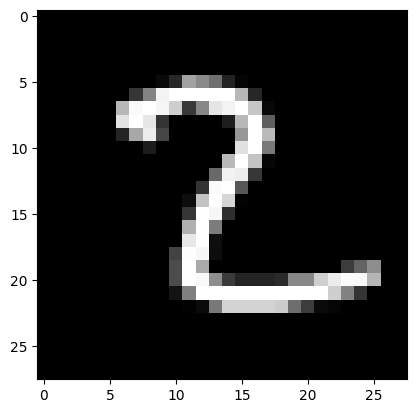

Нейромережа передбачає: 2
Правильна відповідь: 2




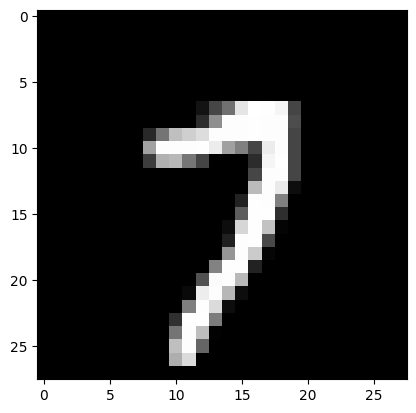

Нейромережа передбачає: 7
Правильна відповідь: 7




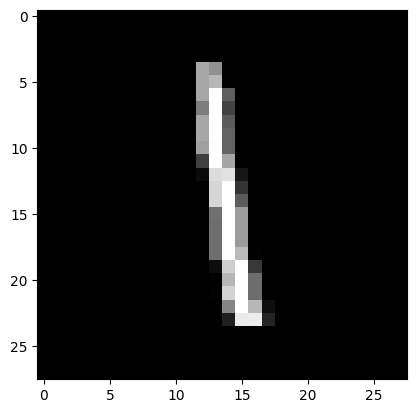

Нейромережа передбачає: 1
Правильна відповідь: 1




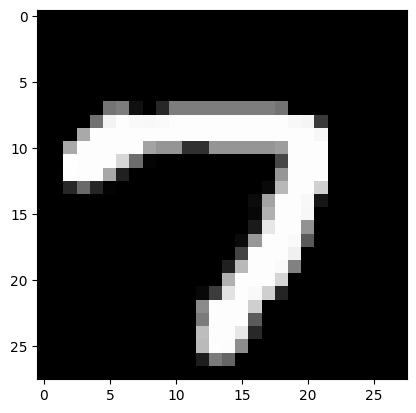

Нейромережа передбачає: 7
Правильна відповідь: 7




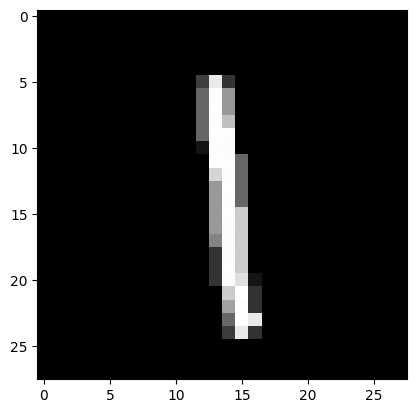

Нейромережа передбачає: 1
Правильна відповідь: 1




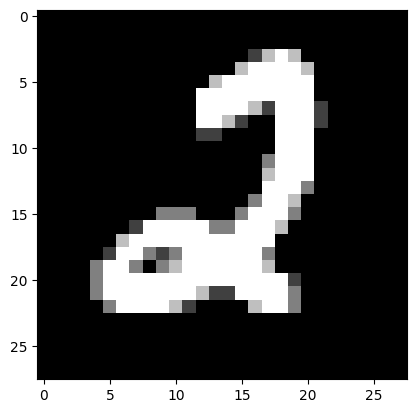

Нейромережа передбачає: 2
Правильна відповідь: 2




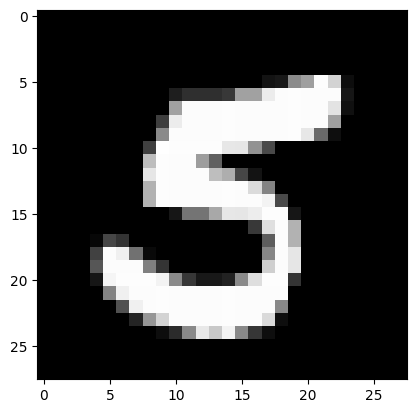

Нейромережа передбачає: 5
Правильна відповідь: 5




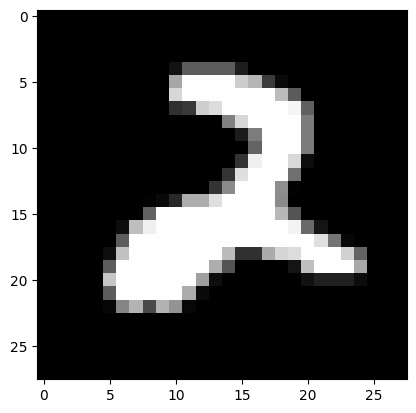

Нейромережа передбачає: 2
Правильна відповідь: 2




In [39]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.

random_images = np.random.permutation(x_test.shape[0])[:10]


for idx in random_images:
    test_image = x_test[idx].reshape(1, -1)
    prediction = neural_net(test_image)

    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.show()

    print(f"Нейромережа передбачає: {tf.argmax(prediction, axis=1).numpy()[0]}")
    print(f"Правильна відповідь: {y_test[idx]}")
    print("\n")


# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?
Точність нейромережі на тестових даних трохи нижча, ніж на навчальних.
Також з Матриці помилок помітно, що є проблеми з класифікацією 4, 5 та 8, хоча у моєму випадку вище була помилка з 2. Графік залежності функції втрат і точності від кількості кроків показує, що точність зростає, а втрати зменшуються, отже навчання моделі більш-менш ефективне.